In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions

In [4]:
sheet = pd.read_excel('data_input_auto/迪拜油.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['Dubai连1合约价格（路透）'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,Dubai连1合约价格（路透）,Brent-Dubai/7DMA,Brent原油期货连1合约价格/路透
2025-12-01,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN


In [5]:
file_path1 = os.path.expanduser("eta/Brent-Dubai_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.head()

,Date,预测值
30,2025-11-08,-0.3
29,2025-11-10,-0.3
28,2025-11-11,-0.4
27,2025-11-12,-0.3
26,2025-11-13,-0.3


In [6]:
file_path2 = os.path.expanduser("eta/Brent原油价格_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['布伦特原油期货价格'])
sheet2 = sheet2.dropna()
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.head()

,Date,Brent原油期货价格预测
20,2025-11-10,63.98
19,2025-11-11,64.92
18,2025-11-12,64.85
17,2025-11-13,64.98
16,2025-11-14,64.20


In [7]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['Brent-Dubai/7DMA'] = sheet_daily['Brent-Dubai/7DMA'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', 'Brent原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['Brent原油期货连1合约价格/路透'] = sheet_daily['Brent原油期货连1合约价格/路透'].fillna(sheet_daily['Brent原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['Brent原油期货价格预测'])


sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]
# 删除所有指定列都为空值的行
sheet_daily.tail()

,Date,Dubai连1合约价格（路透）,Brent-Dubai/7DMA,Brent原油期货连1合约价格/路透
3716,2025-12-01,NaN,-0.3,65.95
3717,2025-12-02,NaN,-0.3,66.09
3718,2025-12-03,NaN,-0.2,66.69
3719,2025-12-04,NaN,-0.2,66.63
3720,2025-12-05,NaN,-0.1,65.18


In [8]:
# 将7日移动平均转换为原始值
# 初始化一个新列用于存储恢复的原始值
sheet_daily['Brent-Dubai_Recovered'] = sheet_daily['Brent-Dubai/7DMA']

# 使用移动平均公式反推原始值
# 原理: MA(t) = [X(t) + X(t-1) + ... + X(t-6)]/7
# 因此: X(t) = 7*MA(t) - [X(t-1) + ... + X(t-6)]
for i in range(len(sheet_daily)-1, 6, -1):
    ma_value = sheet_daily['Brent-Dubai/7DMA'].iloc[i]
    prev_sum = sheet_daily['Brent-Dubai_Recovered'].iloc[i-6:i].sum()
    sheet_daily.loc[sheet_daily.index[i], 'Brent-Dubai_Recovered'] = 7 * ma_value - prev_sum


# 使用原始的Brent-Dubai差价计算Dubai油价预测值
sheet_daily['Dubai连1合约价格（路透）_预测'] = sheet_daily['Brent原油期货连1合约价格/路透'] - sheet_daily['Brent-Dubai_Recovered'] 

In [9]:
sheet_daily.tail()

,Date,Dubai连1合约价格（路透）,Brent-Dubai/7DMA,Brent原油期货连1合约价格/路透,Brent-Dubai_Recovered,Dubai连1合约价格（路透）_预测
3716,2025-12-01,NaN,-0.3,65.95,-0.2,66.15
3717,2025-12-02,NaN,-0.3,66.09,-0.1,66.19
3718,2025-12-03,NaN,-0.2,66.69,0.6,66.09
3719,2025-12-04,NaN,-0.2,66.63,0.5,66.13
3720,2025-12-05,NaN,-0.1,65.18,1.1,64.08


---

In [10]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', 'Dubai连1合约价格（路透）']]
historical.columns = ['Date', 'Dubai']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', 'Dubai连1合约价格（路透）_预测']]
forecast.columns = ['Date', 'Dubai_预测']




# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily = merged_df_daily.dropna(subset=['Dubai','Dubai_预测'],how='all')
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/迪拜油_合并数据.xlsx', index=False,float_format='%.4f')
merged_df_daily

,Date,Dubai,Dubai_预测
762,2025/12/05,NaN,64.08
761,2025/12/04,NaN,66.13
760,2025/12/03,NaN,66.09
759,2025/12/02,NaN,66.19
758,2025/12/01,NaN,66.15
...,...,...,...
4,2023/01/09,76.19,NaN
3,2023/01/06,74.50,NaN
2,2023/01/05,74.16,NaN
1,2023/01/04,75.92,NaN


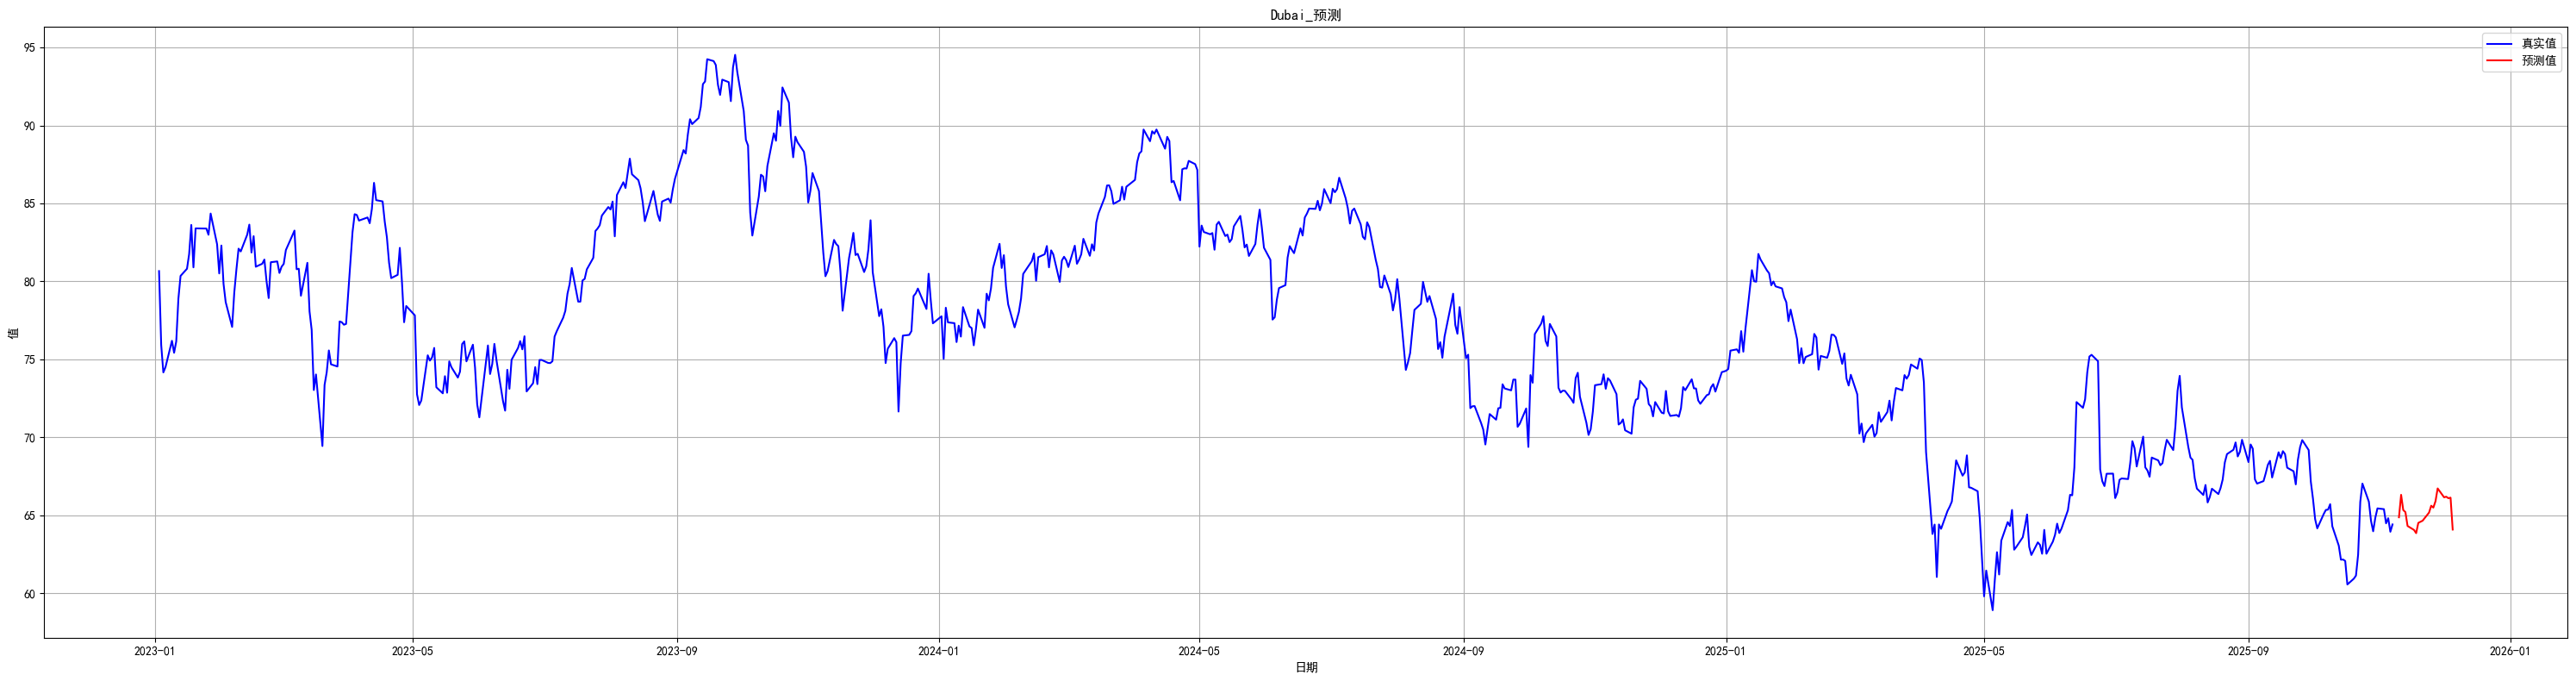

In [11]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['Dubai'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['Dubai_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
#plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('Dubai_预测')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', 'Dubai连1合约价格（路透）']]
historical_monthly.columns = ['Date', 'Dubai']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', 'Dubai连1合约价格（路透）_预测']]
forecast_monthly.columns = ['Date', 'Dubai_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 删除Dubai和Dubai_预测都缺失的行
merged_df_monthly = merged_df_monthly.dropna(subset=['Dubai', 'Dubai_预测'], how='all')

merged_df_monthly.to_excel('eta/迪拜油_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly.head()

,Date,Dubai,Dubai_预测
35,2025/12/31,NaN,65.728000
34,2025/11/30,64.606000,65.065810
33,2025/10/31,64.040000,63.810400
32,2025/09/30,68.328636,67.920714
31,2025/08/31,68.038571,69.030862


In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "Dubai价格"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "详情页"
identifier = "Dubai价格"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [15]:
merged_df_daily

,Date,Dubai,Dubai_预测
762,2025/12/05,NaN,64.08
761,2025/12/04,NaN,66.13
760,2025/12/03,NaN,66.09
759,2025/12/02,NaN,66.19
758,2025/12/01,NaN,66.15
...,...,...,...
4,2023/01/09,76.19,NaN
3,2023/01/06,74.50,NaN
2,2023/01/05,74.16,NaN
1,2023/01/04,75.92,NaN


In [16]:
count_prediction = merged_df_daily.copy()
# 将实际值和预测值合并为一列
count_prediction['预测叠加'] = count_prediction['Dubai'].fillna(count_prediction['Dubai_预测'])
# 将日期列转换为datetime格式
count_prediction['Date'] = pd.to_datetime(count_prediction['Date'])
# 设置日期为索引
count_prediction.set_index('Date', inplace=True)
# 获取每月最后一天的数据
count_monthly_data = count_prediction.resample('ME').last()
# 重置索引并格式化日期
count_monthly_data = count_monthly_data.reset_index()
count_monthly_data['Date'] = count_monthly_data['Date'].dt.strftime('%Y/%m/%d')
# 显示结果
print(count_monthly_data[['Date', '预测叠加']].tail())


          Date   预测叠加
31  2025/08/31  69.84
32  2025/09/30  67.15
33  2025/10/31  65.44
34  2025/11/30  66.72
35  2025/12/31  64.08
